<a href="https://colab.research.google.com/github/bonvech/MSU-AI/blob/main/Bonvech_EX12_Representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Функции для обучения автоэнкодеров

In [4]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.4 MB/s eta 0:00:00


In [5]:
import torch
import numpy as np
import lightning as L
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from warnings import simplefilter

simplefilter("ignore", UserWarning)
simplefilter("ignore", RuntimeWarning)

In [76]:
def plot_manifold(latent_r, labels=None, alpha=0.9, classes=None, title=None):
    plt.figure(figsize=(8, 8))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], alpha=alpha)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        cbar = plt.colorbar()
    if classes:
        num_of_classes = list(range(0, len(classes)))
        cbar.ax.set_yticks(num_of_classes)
        cbar.ax.set_yticklabels(classes)
    if title:
        plt.title(title)
    plt.show()


# plotting reconstructed and noised images
def plot_samples(*args, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [77]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256]  # num of filters in layers
        modules = []
        in_channels = 1  # initial value of channels
        for h_dim in hidden_dims:  # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,  # num of input channels
                        out_channels=h_dim,  # num of output channels
                        kernel_size=3,
                        stride=2,  # convolution kernel step
                        padding=1,  # save shape
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim  # changing number of input channels for next iteration

        modules.append(nn.Flatten())  # to vector, size 256 * 2 * 2 = 1024
        modules.append(nn.Linear(256 * 2 * 2, latent_dim))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [256, 128, 64, 32]  # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=1024)

        modules = []
        for i in range(len(hidden_dims) - 1):  # define upsample layers
            modules.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=5),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)  # from latents space to Linear
        x = x.view(-1, 256, 2, 2)  # reshape
        x = self.decoder(x)  # reconstruction
        return x

In [78]:
class LitAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)
        return latent, recon

    def loss_handler(self, recon, data, *args, **kwargs):
        # here is the loss function computing
        loss = F.mse_loss(F.sigmoid(recon), data)
        return loss

    def training_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_start(self):
        # create dict with empty tensors for further accumulating over batches
        self.test_result = defaultdict(torch.Tensor)

    def test_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        recon = F.sigmoid(recon)
        self.update_test_result(data, recon, latent, labels)

    def update_test_result(self, data, recon, latent, labels):
        # accumulating results every batch
        self.test_result["real"] = torch.cat([self.test_result["real"], data.cpu()])
        self.test_result["recon"] = torch.cat([self.test_result["recon"], recon.cpu()])
        self.test_result["latent"] = torch.cat(
            [self.test_result["latent"], latent.cpu()]
        )
        self.test_result["labels"] = torch.cat(
            [self.test_result["labels"], labels.cpu()]
        )

    def on_test_epoch_end(self):
        # simply change type from torch tensor to numpy array
        # for every item in test_result dictionary
        for key in self.test_result:
            self.test_result[key] = self.test_result[key].numpy()

# Задание 1. Автоэнкодер для FashionMNIST c SSIM loss

В этом задании требуется обучить автоэнкодер на датасете FashionMNIST.

* Используйте энкодер и декодер из лекции (код `Encoder`, `Decoder` выше).
* Замените функцию потерь при обучении автоэнкодера на `SSIM loss` [📚[wiki]](https://ru.wikipedia.org/wiki/SSIM).
* Обучите автоэнкодер с размером латентного слоя 2.
* Выведите латентное представление объектов на плоскости. Проанализируйте, разделяются ли в нем классы?

Далее:

* Обучите автоэнкодер с размером латентного слоя 30.
* Продемонстрируйте восстановление автоэнкодером переданных ему изображений.

Напишите выводы.

**Подсказки:**

* Для обучения и тестирования воспользуйтесь Lightning-модулем `LitAE` (код выше). Для того, чтобы заменить функцию потерь, рекомендуется отнаследоваться от `LitAE` и переопределить метод `loss_handler`, заменив функцию потерь в нем.
* Для визуализации латентных представлений на плоскости рекомендуется использовать функцию `plot_manifold` (код выше).
* Для визуализации оригинальных изображений и их реконструкций рекомендуется использовать функцию `plot_samples` (код выше).

Импорт необходимых библиотек:

In [79]:
import numpy as np
import lightning as L
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from lightning.pytorch.loggers import TensorBoardLogger

Загрузка датасета:

In [80]:
root = "./data"

train_set = FashionMNIST(
    root=root, train=True, transform=transforms.ToTensor(), download=True
)
test_set = FashionMNIST(
    root=root, train=False, transform=transforms.ToTensor(), download=True
)

torch.manual_seed(42)
train_set, val_set = random_split(train_set, lengths=[50000, 10000])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

В датасете 10 классов, каждый соответствует одному из предметов гардероба.

In [81]:
# Method for display all class samples from dataset
def show_dataset(dataset):
    fig, axs = plt.subplots(1, len(dataset.classes), figsize=(20, 5))
    for cls_num, name in enumerate(dataset.classes):
        i = np.argwhere(dataset.targets == cls_num)[0][0]
        ax = axs[cls_num]
        ax.imshow(dataset.data[i], cmap="gray_r")
        ax.set_title(name)
        ax.axis("off")
    plt.show()

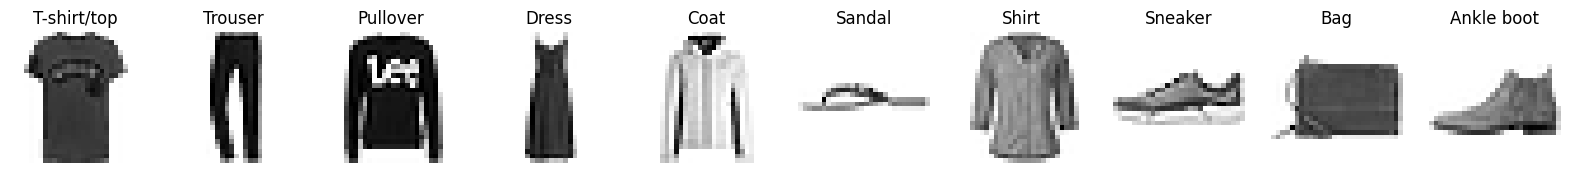

In [82]:
show_dataset(test_set)

Задайте `latent_dim` равным 2 для последующего построения отображения латентных представлений на плоскости. Инициализируйте модели энкодера и декодера.

In [83]:
L.seed_everything(42)

latent_dim = 2  # Your code here
encoder = Encoder(latent_dim=latent_dim) # Your code here
decoder = Decoder(latent_dim=latent_dim) # Your code here

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Опишите класс-наследник `LitAE`, который будет использовать `SSIM loss` [📚[wiki]](https://ru.wikipedia.org/wiki/SSIM) в качестве функции потерь для автоэнкодера внутри `loss_handler`. Можно воспользоваться готовой [реализацией 🐾[git]](https://github.com/VainF/pytorch-msssim):

In [84]:
!pip install pytorch-msssim

In [93]:
from pytorch_msssim import ssim, SSIM

class LitAE_with_SSIM(LitAE):
    #def __init__(self):
    #    super().__init__()


    def loss_handler(self, recon, data, *args, **kwargs):
        # Your code here
        #loss = F.mse_loss(F.sigmoid(recon), data)
        #ssim_torch = ssim(img_noise_torch, img_torch, win_size=11, data_range=255)
        #ssim_loss = 1 - ssim(recon, data)
        #ssim_loss = ssim(recon, data)
        ssim_module = SSIM(data_range=255, size_average=True, channel=1) # channel=1 for grayscale images
        ssim_loss = 1 - ssim_module(F.sigmoid(recon), data)

        return ssim_loss

Наконец, обучите автоэнкодер.

In [94]:
from lightning.pytorch.loggers import TensorBoardLogger

# Your code here
autoencoder = LitAE_with_SSIM(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 390 K 
1 | decoder | Decoder | 391 K 
------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.130     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Для прогона тестовых данных через автоэнкодер воспользуйтесь `trainer.test`. Результат тестирования будет записан в словарь в атрибуте `.test_result` Lightning-модели автоэнкодера.

In [95]:
# Your code here
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

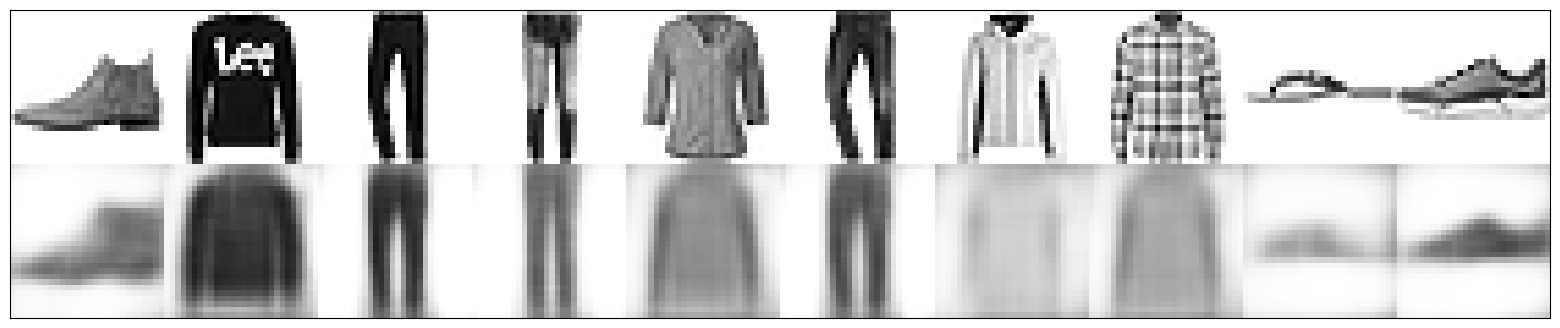

In [96]:
real = run_res["real"]
recon = run_res["recon"]
plot_samples(real[0:10], recon[0:10])

Выведите латентное представление объектов на плоскости. Проанализируйте, разделяются ли в нем классы? Какие классы смешиваются, а какие хорошо отделяются?

У функции `plot_manifold` есть аргумент `classes`. В него можно передать список названий классов (`test_set.classes`) для отображения названий вместо номеров классов.

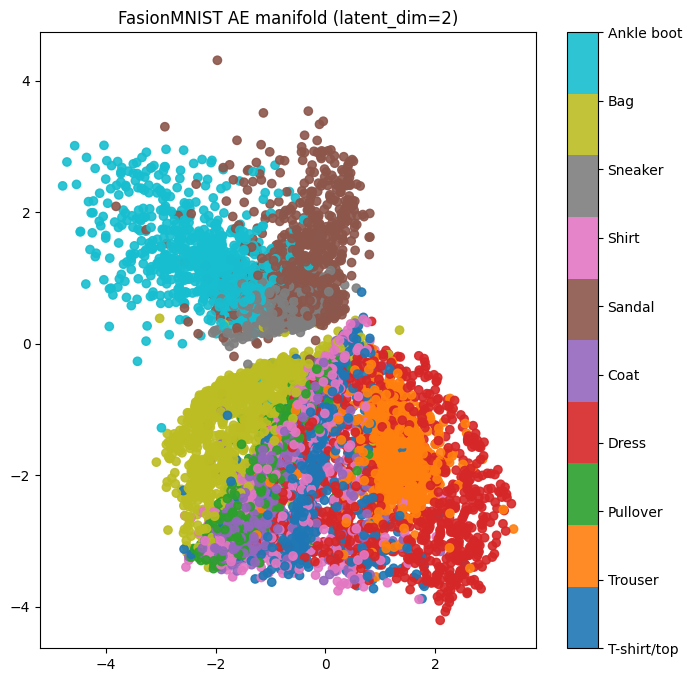

In [102]:
# Your code here
plot_manifold(run_res["latent"], run_res["labels"], title="FasionMNIST AE manifold (latent_dim=2)", classes=test_set.classes)

*Ваши наблюдения:*

***Обувь очень хорошо отделяется от одежды, но между собой разные типы обуви не очень хорошо разделяются.***

***Также неплохо выделяются сумки.***

***Вся остальная одежда не отличается друг от друга.***


Теперь обучите автоэнкодер с размером латентного слоя 30.

In [99]:
# Your code here
latent_dim = 30
encoder = Encoder(latent_dim=latent_dim) # Your code here
decoder = Decoder(latent_dim=latent_dim) # Your code here

autoencoder = LitAE(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 419 K 
1 | decoder | Decoder | 420 K 
------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.359     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Обработайте автоэнкодером тестовые данные. Продемонстрируйте восстановление автоэнкодером переданных ему изображений. Используйте функцию `plot_samples`.

In [100]:
# Your code here
trainer.test(autoencoder, test_loader)
run_res_30 = autoencoder.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

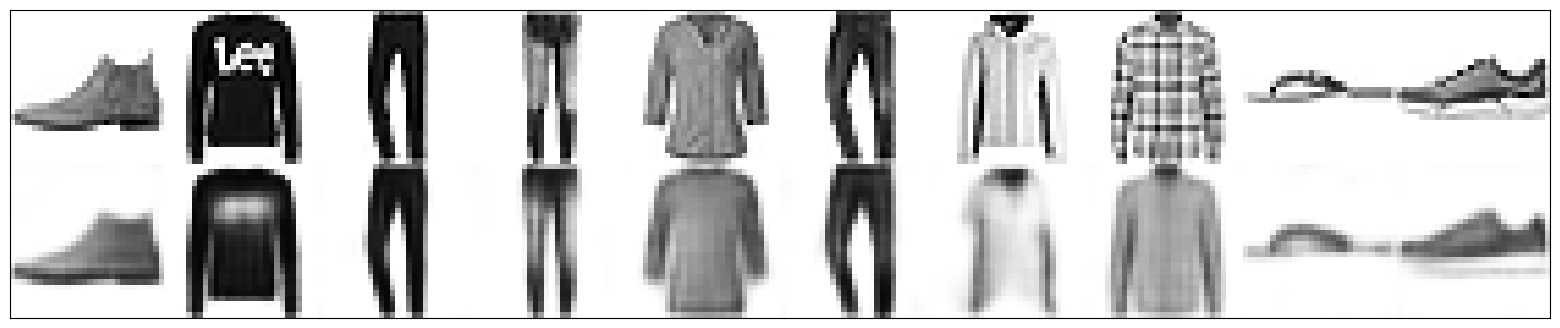

In [101]:
real = run_res_30["real"]
recon = run_res_30["recon"]
plot_samples(real[0:10], recon[0:10])

Какие особенности в восстановленных изображениях по сравнению с исходными вы можете отметить?

*Ваши наблюдения:*

***При увеличении размерности латентного слоя до 30 качество восстановленных образов становится лучше, прорисовываются более подробные детали изображения.***

## Формат результата

1. Визуализация латентного пространства для автоэнкодера с `latent_dim=2`, **выводы**. Пример визуализации:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/result_1_1_task_ex12.png" width="500"/>


2. Изображения, восстановленные автоэнкодером c `latent_dim=30`, **выводы**. Пример изображений:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/result_2_1_task_ex12.png" width="500"/>



# Задание 2. Обнаружение аномалий с помощью автоэнкодера

Представим следующую ситуацию: нам нужна система, которая принимает изображение сетчатки глаза. Если изображение не является фотографией сетчатки глаза, то система должна сообщить пользователю об ошибке и не принимать это изображение.

Идея заключается в следующем: если автоэнкодер может выучить внутреннее представление данных, например, фотографий сетчатки глаза, то при восстановлении данных, которые не являются фотографией сетчатки глаза, ошибка будет существенно больше. Установив порог этой ошибки, мы сможем отделять нужные фотографии от ненужных.

* Обучите автоэнкодер на фотографиях сетчатки глаза (RetinaMNIST).
* Подайте в автоэнкодер другое изображение (здесь будет использован BloodMNIST).
* Посчитайте ошибку восстановления для разных датасетов.
* Установите порог (значение ошибки) для определения класса фотографии (сетчатка глаза или нет).
* Проведите тесты.
* Напишите выводы.

Установка и импорт необходимых библиотек:

In [53]:
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [103]:
import medmnist
import numpy as np
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt

from medmnist import INFO
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from lightning.pytorch.loggers import TensorBoardLogger

[[doc] 🛠️ MedMNIST](https://medmnist.com/) — это набор медицинских датасетов, по формату повторяющих MNIST:

* размер изображений 28×28,
* совместимы с PyTorch ([пример использования🐾[git]](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb)).

В этом задании будем работать с двумя датасетами: RetinaMNIST и BloodMNIST.

Первый содержит изображения сетчатки глаз, второй — клеток крови.

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


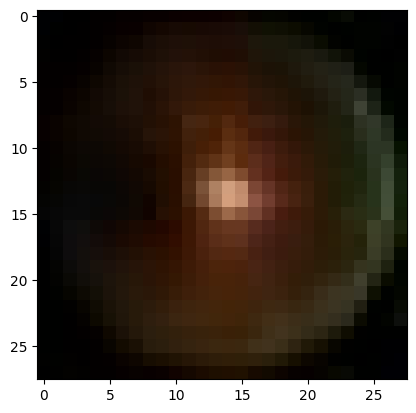

In [104]:
import medmnist
from medmnist import INFO

DataClass = getattr(medmnist, INFO["retinamnist"]["python_class"])

train_retina_dataset = DataClass(split="train", download=True)
val_retina_dataset = DataClass(split="val", download=True)

plt.imshow(val_retina_dataset[0][0])
plt.show()

Несмотря на заявленную совместимость с PyTorch, у датасетов нет свойств `targets` и `data`.

Но есть словарь `info` ([код 🐾[git]](https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/dataset.py)).

In [105]:
info = val_retina_dataset.info
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'url_64': 'https://zenodo.org/records/10519652/files/retinamnist_64.npz?download=1',
 'MD5_64': 'afda852cc34dcda56f86ad2b2457dbcc',
 'url_128': 'https://zenodo.org/records/10519652/files/retinamnist_128.npz?download=1',
 'MD5_128': 'e48e916a24454daf90583d4e6efb1a18',
 'url_224': 'https://zenodo.org/records/10519652/files/retinamnist_224.npz?download=1',
 'MD5_224': 'eae7e3b6f3fcbda4ae613ebdcbe35348',
 'task': 

В нем есть аналогичное `targets` свойство `labels`, а у самого объекта есть массив `imgs`, аналогичный `data` в torchvision датасетах.

In [106]:
print("labels", val_retina_dataset.labels.shape)
print("images", val_retina_dataset.imgs.shape)

labels (120, 1)
images (120, 28, 28, 3)


Используя эти свойства, можно сделать датасет совместимым с нашим кодом, написанным для MNIST:

In [107]:
def cast2torch(ds):
    ds.targets = ds.labels
    ds.data = ds.imgs
    ds.classes = list(info["label"].values())


cast2torch(val_retina_dataset)
cast2torch(train_retina_dataset)

**RetinaMNIST classes**

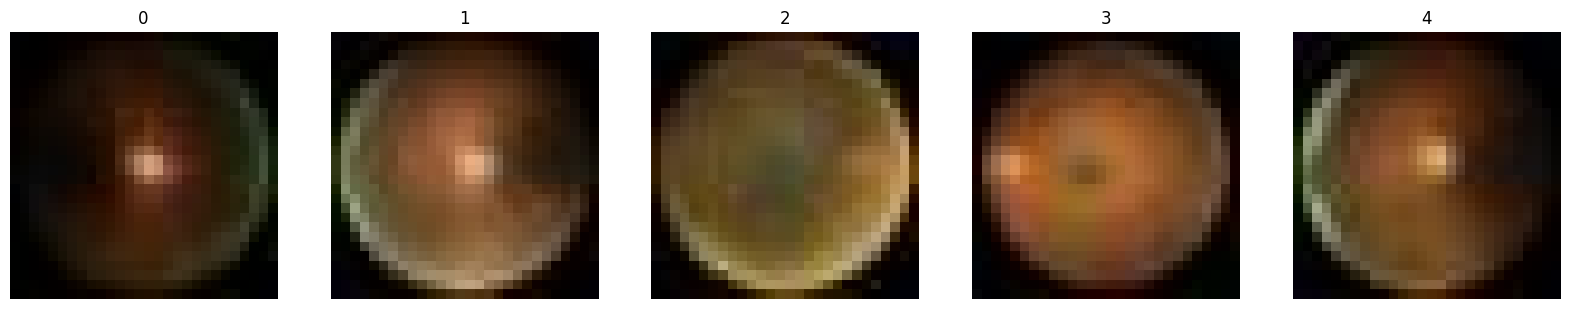

In [108]:
show_dataset(val_retina_dataset)

Названий классов тут нет, но для нашей задачи они нам и не понадобятся.
Теперь загрузим датасет с клетками крови:

**BloodMNIST classes**

In [109]:
DataClass = getattr(medmnist, INFO["bloodmnist"]["python_class"])
test_blood_dataset = DataClass(split="test", download=True)
cast2torch(test_blood_dataset)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


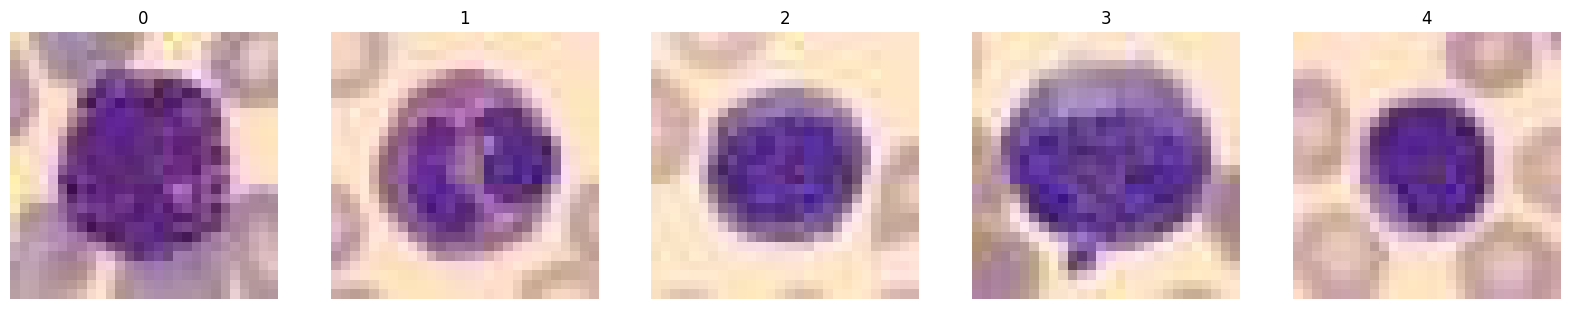

In [110]:
show_dataset(test_blood_dataset)

По форме клетки крови отдаленно напоминают фото сетчатки.

Представим, что при сборе новой порции данных фотографии клеток крови по ошибке попали в папку с фотографиями сетчатки и были включены в новую версию датасета.

Нам надо исправить ошибку и отделить фото клеток сетчатки от фото клеток крови.

Для этого обучим автоэнкодер на той части датасета, которая была собрана раньше и не содержит ошибок. Будем считать, что это `train_retina_dataset`.

Обучим на них автоэнкодер. Для этого создадим загрузчики и добавим трансформации к датасетам. В частности, сделаем изображения черно-белыми, чтобы использовать пайплайн из предыдущего задания.

In [111]:
data_transform = transforms.Compose(
    [
        # Convert all images to Grayscale for sake of MNIST compatibility
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

train_retina_dataset.transform = data_transform
val_retina_dataset.transform = data_transform
test_blood_dataset.transform = data_transform

# encapsulate data into dataloader form
train_loader = DataLoader(
    train_retina_dataset, batch_size=128, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_retina_dataset, batch_size=1, shuffle=False, num_workers=2)
blood_loader = DataLoader(
    test_blood_dataset, batch_size=1, shuffle=False, num_workers=2
)

Создайте энкодер и декодер (`latent_dim=2`) и обучите AE 15–30 эпох (занимает несколько секунд).

Можно использовать `LitAE`, в котором в качестве функции потерь используется MSE, или `LitAE_with_SSIM`.

In [112]:
# Your code here
latent_dim=2
encoder = Encoder(latent_dim=latent_dim) # Your code here
decoder = Decoder(latent_dim=latent_dim) # Your code here

autoencoder = LitAE(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 390 K 
1 | decoder | Decoder | 391 K 
------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.130     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Посмотрим, как автоэнкодер научился восстанавливать изображения сетчатки, на которых его учили:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

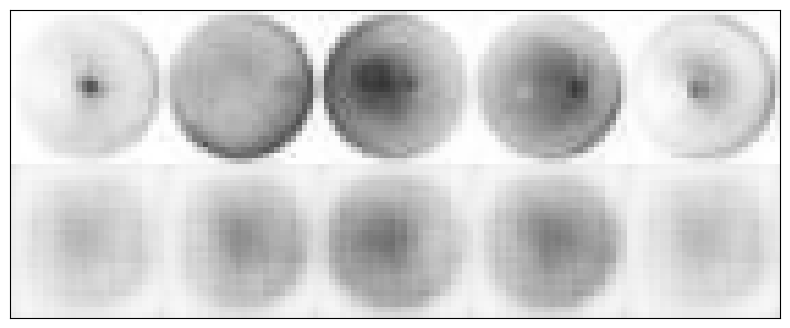

MSE for correct retina images 0.01683733


In [144]:
def get_mse_and_show_results(dataloader):
    trainer.test(autoencoder, dataloader)
    run_res = autoencoder.test_result

    real = run_res["real"]
    recon = run_res["recon"]

    cnt = len(real)
    mse = mean_squared_error(
        real.reshape(-1, cnt), recon.reshape(-1, cnt), multioutput="raw_values"
    )

    plot_samples(real[0:5], recon[0:5])
    return mse


mse_retina = get_mse_and_show_results(val_loader)
print("MSE for correct retina images", mse_retina.mean())

Теперь посмотрим, что будет, если попытаться восстановить изображения клеток крови:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

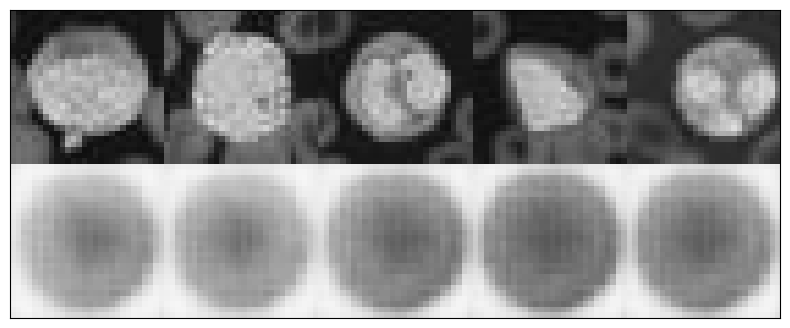

MSE for blood cell images 0.22545835


In [145]:
mse_blood = get_mse_and_show_results(blood_loader)
print("MSE for blood cell images", mse_blood.mean())

Видно, что автоэнкодер пытается восстанавливать фотографии сетчатки и ошибка на порядок больше. Можно разделить фотографии по значению ошибки восстановления.

В качестве "испорченного датасета" возьмем `val` чаcть из RetinaMnist и `test` часть из BloodMnist.

Постройте гистограммы ошибок `mse_retina` и `mse_blood`:

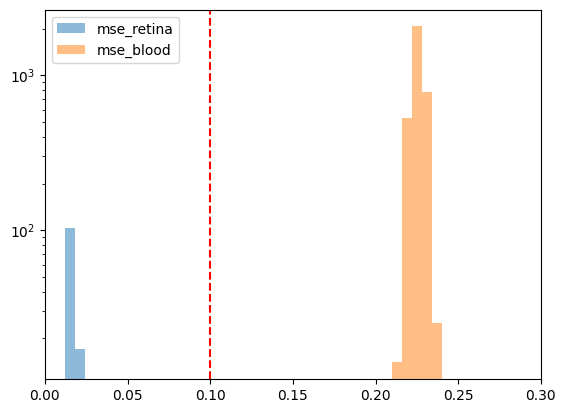

In [187]:
# Your code here
bins = 50
plt.hist(mse_retina, bins=bins, range=(0,0.3), label="mse_retina", alpha=0.5)
plt.hist(mse_blood,  bins=bins, range=(0,0.3), label="mse_blood",  alpha=0.5)
plt.axvline(0.1, color='r', linestyle="--")
plt.xlim(0,0.3)
plt.semilogy()
plt.legend();

Выберите порог ошибки восстановления и вычислите метрики качества отделения снимков сетчатки от снимков крови: accuracy, precision, recall, f1-score.

In [190]:
threshold = 0.1

              precision    recall  f1-score   support

       blood       1.00      1.00      1.00       120
      retina       1.00      1.00      1.00      3421

    accuracy                           1.00      3541
   macro avg       1.00      1.00      1.00      3541
weighted avg       1.00      1.00      1.00      3541



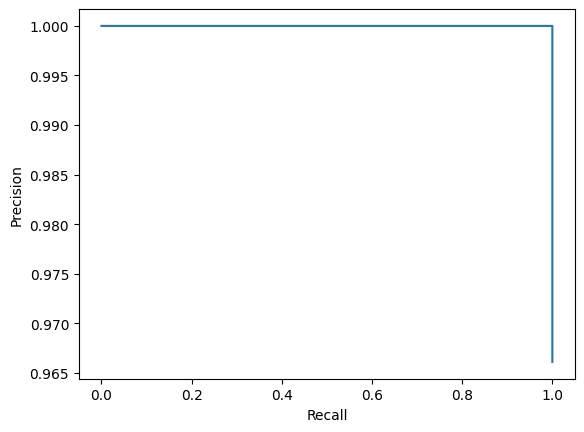

In [191]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import classification_report

# Your code here
target_names = ["blood", "retina"]
y_true = [1] * len(mse_blood) + [0] * len(mse_retina)

y_pred = list(map(lambda x: 1 if x > threshold else 0, mse_blood)) +  list(map(lambda x: 1 if x > label else 0, mse_retina))
print(classification_report(y_true, y_pred, target_names=target_names))


y_pred =  list(mse_blood) + list(mse_retina)
#y_pred = [1 - x for x in y_pred]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.show()


f1 = (precision * recall) / (precision + recall)
#plt.plot(thresholds, f1[1:], "o")
#plt.xlabel('threshold')
#plt.grid()
#plt.ylabel('f1');

## Формат результата

Метрики качества отделения снимков сетчатки от снимков крови: accuracy, precision, recall, f1-score — не менее 0.95.

# Задание 3. Поиск hard examples с помощью автоэнкодера

В этом задании требуется найти самые "некрасивые" цифры в **обучающей выборке** MNIST. Найдите изображения цифр, которые хуже всего восстанавливаются автоэнкодером.

Один из возможных подходов:
* Обучить автоэнкодер на датасете MNIST.
* Посчитать ошибку восстановления для каждой картинки обучающей выборки.
* Отсортировать список ошибок восстановления и получить индексы изображений с наибольшей ошибкой.
* Отрисовать такие изображения.

В качестве критерия качества восстановления можно использовать как функцию потерь, так и другие меры сходства изображений, например, [structural similarity index 🛠️[doc]](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html).

## Формат результата

Вывести изображения обучающей выборки с наихудшим качеством восстановления автоэнкодером.

Пример результата:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/result_3_task_ex12.png" width="800">

Импорт необходимых библиотек:

In [198]:
import numpy as np
import lightning as L
import torch.nn.functional as F

from torchvision import transforms
from collections import defaultdict
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from lightning.pytorch.loggers import TensorBoardLogger

Загрузка датасета:

In [200]:
root = "./data"

train_set = MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
torch.manual_seed(42)
train_set, val_set = random_split(train_set, lengths=[50000, 10000])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

In [264]:
# Your code here
# Обучить автоэнкодер на датасете MNIST.
latent_dim = 10
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitAE(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 399 K 
1 | decoder | Decoder | 399 K 
------------------------------------
798 K     Trainable params
0         Non-trainable params
798 K     Total params
3.195     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [265]:
# Посчитать ошибку восстановления для каждой картинки обучающей выборки.
trainer.test(autoencoder, test_loader)
run_res_3 = autoencoder.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [266]:
real = run_res_3["real"]
recon = run_res_3["recon"]

cnt = len(real)
mse = mean_squared_error(
    real.reshape(-1, cnt), recon.reshape(-1, cnt), multioutput="raw_values"
)
print(mse)

[0.0143957  0.01689591 0.01288814 ... 0.01301497 0.01147522 0.013545  ]


In [270]:
#msetop = sorted(mse)[:10]
msetop = sorted(mse, reverse=True)[:10]
print(msetop)

[0.022161627, 0.021500185, 0.020523038, 0.020335091, 0.0202634, 0.020045271, 0.02003585, 0.0200165, 0.020010851, 0.020000968]


In [271]:
[np.where(mse == msetop[i]) for i in range(10)]

[(array([3183]),),
 (array([3500]),),
 (array([6017]),),
 (array([493]),),
 (array([5340]),),
 (array([3538]),),
 (array([859]),),
 (array([3539]),),
 (array([2975]),),
 (array([1129]),)]

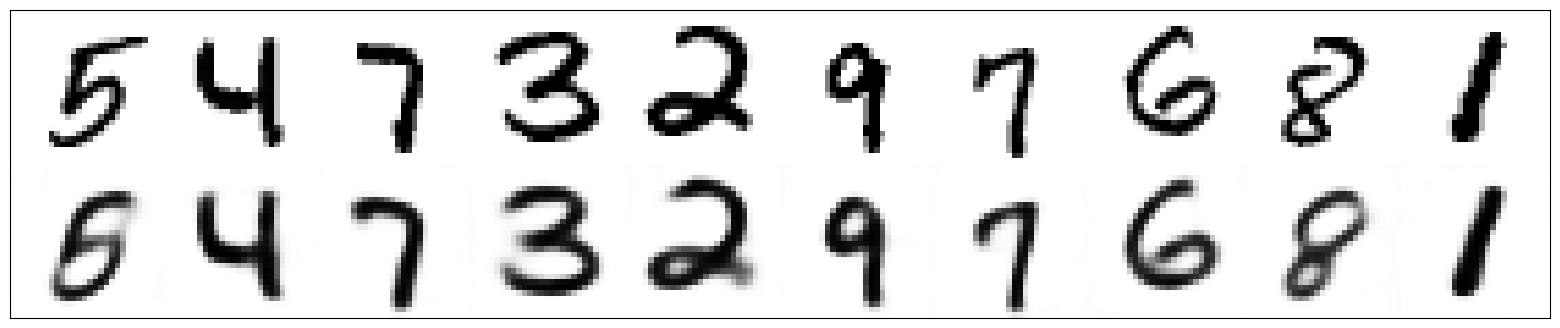

In [272]:
#define values of interest
vals = np.array(msetop)

#find index location of first occurrence of each value of interest
sorter = np.argsort (mse)
idxx = sorter[np.searchsorted (mse, vals, sorter=sorter)]


plot_samples(run_res_3["real"][idxx], run_res_3["recon"][idxx])

# Задание 4. Перенос стиля при помощи CVAE

С помощью CVAE можно решать задачу переноса стиля. Посмотрите на результат переноса стиля нескольких разных семерок на другие цифры:



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/style_transfer.png" width="500">

Ваша задача:
- Обучите CVAE, как в лекции (`latent_dim=2...10`). Вам понадобятся условный декодер `CDecoder` и `LitCVAE`.

- Возьмите 10 случайных троек из тестового датасета и реализуйте перенос стиля троек на другие цифры.

- Выведите визуализацию, как в примере. На вашей визуализации тройки должны быть исходные, а остальные цифры — полученные в результате переноса стиля.

Импорт необходимых библиотек:

In [194]:
import torch
import numpy as np
import lightning as L
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from lightning.pytorch.loggers import TensorBoardLogger

Загрузка датасета:

In [195]:
root = "./data"

train_set = MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
test_set  = MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

torch.manual_seed(42)
train_set, val_set = random_split(train_set, lengths=[50000, 10000])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [196]:
class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0:  # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")

        super().__init__(latent_dim)

In [197]:
class LitVAE(LitAE):
    def __init__(self, encoder, decoder, kld_weight=0.005, recon_weight=1.0):
        super().__init__(encoder, decoder)
        self.kld_weight = kld_weight
        self.recon_weight = recon_weight

    def vae_split(self, latent):
        size = (
            latent.shape[1] // 2
        )  # divide the latent representation into mu and log_var
        mu = latent[:, :size]
        log_var = latent[:, size:]
        return mu, log_var

    def vae_reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn(mu.shape[0], mu.shape[1]).to(self.device)
        return eps * sigma + mu

    def kld_loss(self, mu, log_var):
        var = log_var.exp()
        kl_loss = torch.mean(-0.5 * torch.sum(log_var - var - mu**2 + 1, dim=1), dim=0)
        return kl_loss

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample)
        return latent, recon

    def loss_handler(self, recon, data, latent, *args, **kwargs):
        mu, log_var = self.vae_split(latent)
        # here is the loss function computing
        loss = self.recon_weight * F.mse_loss(
            F.sigmoid(recon), data
        ) + self.kld_weight * self.kld_loss(mu, log_var)
        return loss

1. Воспользуйтесь кодом для `CDecoder` и `LitCVAE` из лекции, чтобы обучить свой CVAE. В качестве энкодера используйте `VAEEncoder`. Достаточно обучать 5 эпох.

In [ ]:
# Your code here

2. Обработайте тестовые данные с помощью CVAE.

In [ ]:
# Your code here

3. Из словаря, полученного в результате обработки тестовых данных, отберите 10 случайных троек (вам помогут ключи `"labels"` и `"real"`). Выведите их с помощью функции `plot_samples`.

In [ ]:
# Your code here

4. Теперь вам нужно обработать ваши тройки **энкодером** и получить для них латентные представления, кодирующие стиль начертания. Далее в цикле по $i$ от 0 до 9 подать в декодер латентные представления ваших троек и метку $i$-той цифры.

Подсказка: вне цикла создайте пустой список `images`, а в цикле добавляйте в него результат работы декодера с $i$-той цифрой.

In [ ]:
# Your code here

In [ ]:
plot_samples(*images)  # result

## Формат результата

Перенести стили троек на другие цифры. При этом сами тройки должны вывестись исходные.

Пример результата:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/result_4_task_ex12.png" width="500">

# Задание 5. Сиамская сеть

С помощью сиамской сети решим задачу с Kaggle.

Цель: обучить сиамскую модель отличать поддельные подписи.

[[doc] 🛠️ Signature verification dataset (Kaggle)](https://www.kaggle.com/robinreni/signature-verification-dataset)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX12/signature_verification_dataset.png" width="600">

Датасет состоит из набора сканов подписей, разложенных по папкам согласно следующей структуре:

```
sign_data_mini/
├── train
|   ├── 001
|   |   ├── 001_01.PNG
|   |   ├ ...
|   |   └── 001_24.PNG
|   ├── 001_forg
|   |   └── ...
|   ├ ...
|   ├── 030
|   |   └── ...
|   └── 030_forg
|       └── ...
└── test
    ├── 049
    |   └── ...
    |
    ├── 049_forg
    |   └── ...
    ├ ...
    ├── 051
    |   └── ...
    └── 051_forg
        └── ...

```



В папке `id1` содержатся сканы подлинных подписей одного человека. В папке `id1_forg` содержатся сканы поддельных подписей того же человека.

В папках с префиксом `id2`, `id2_forg` — настоящие и поддельные подписи другого человека и т. д.

В папке `train` собраны оригинальные и поддельные подписи тридцати человек (`id = 001 ... 030`), а в папке `test` — оригинальные и поддельные подписи трех человек, отличных от тридцати "обучающих" (`id = 049 ... 051`).

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q timm
!pip install -q lightning
!pip install -q torchmetrics

In [ ]:
import os
import timm
import torch
import numpy as np
import torchvision
import torchmetrics
import pandas as pd
import lightning as L
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from glob import glob
from PIL import Image
from itertools import product
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.functional import cosine_similarity
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from warnings import simplefilter

simplefilter("ignore", UserWarning)
simplefilter("ignore", RuntimeWarning)

## Загрузка датасета

Загрузим фрагмент датасета, достаточный для выполнения задания:

In [ ]:
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/sign_mini.zip
!unzip -qn sign_mini.zip

Класс датасета дан готовым.

В отличие от датасетов для классификации, метод `__getitem__` возвращает кортеж не из двух, а из трех элементов:

1. Реальная подпись, соответствующая индексу `index`.
2. Подпись, с которой ее нужно сравнить. С вероятностью 0.5 это может быть другая настоящая подпись и с вероятностью 0.5 — подделка.
3. Метка, соответствующая результату сопоставления. Для двух настоящих подписей это $1$. Для ситуации, когда одна из подписей поддельная, это $-1$.

Необходимости изменять этот класс нет, однако это допустимо.

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, dir=None, transform=None):
        self.dir = dir
        self.transform = transform
        self.classes = {1: "Original", -1: "Forged"}  # Change if need
        self.data = self.get_pairs()
        self.targets = self.get_targets()
        self.cache = {}

    def get_pairs(self):
        pairs = []  # to store [orig, fake] or [orig, orig] pairs
        persons = self.load_data()
        for key in persons:
            all_pairs = product(
                persons[key]["orig"], persons[key]["orig"] + persons[key]["forg"]
            )
            # remove pairs with themselve
            without_self_comparsion = list(filter(lambda x: x[0] != x[1], all_pairs))
            pairs += without_self_comparsion
        return pairs

    def load_data(self):
        all_paths = glob(f"{self.dir}/**/*")  # get all files path
        persons = {}
        # Group files by ID and type
        for path in all_paths:
            id, tp = SiameseNetworkDataset.parse(path)
            if not id in persons:
                persons[id] = {"orig": [], "forg": []}
            persons[id][tp].append(path)
        return persons

    def get_targets(self):
        targets = []
        for pair in self.data:
            _, tp = SiameseNetworkDataset.parse(pair[1])
            label = -1 if tp == "forg" else 1
            targets.append(label)
        return targets

    @staticmethod
    def parse(path):
        folder = path.split(os.sep)[-2]
        id = folder.split("_")[0]
        tp = "forg" if "forg" in path else "orig"
        return id, tp

    def __getitem__(self, index):
        image1_path, image2_path = self.data[index]
        labels = self.targets[index]

        # Loading the images
        image1 = self.load(image1_path)
        image2 = self.load(image2_path)

        return image1, image2, labels

    def load(self, path):
        if path in self.cache:
            img = self.cache[path]
        else:
            img = Image.open(path).convert("L")
            self.cache[path] = img
        # Apply image transformations
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)

Создадим экземпляр датасета и убедимся, что данные загружаются:

In [ ]:
# Viewing the sample of images to check whether its loading properly
print('"1" - real, "-1" - fake')

vis_dataset = SiameseNetworkDataset(
    "/content/sign_data_mini/train",
    transform=transforms.Compose(
        [
            transforms.Resize((105, 105)),
            transforms.ToTensor(),
        ]
    ),
)

vis_dataloader = DataLoader(vis_dataset, batch_size=8, shuffle=True)

example_batch = next(iter(vis_dataloader))  # images1, images2, labels
images1, images2, labels = example_batch
# display the data
concatenated = torch.cat((images1, images2), dim=0)
grid = torchvision.utils.make_grid(concatenated)

plt.figure(figsize=(20, 40))
plt.axis("off")

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()

print(labels.numpy())

Оценим баланс классов:

In [ ]:
# For check classes balance
plt.hist(vis_dataset.targets)
plt.show()

## Создание тренировочного и тестового датасетов и загрузчиков данных

В отличие от загрузчиков данных для визуализации, здесь в трансформациях присутствует нормализация.

Этот блок можно модифицировать.

In [ ]:
# Define transforms include Normalization
transform = transforms.Compose(
    [
        transforms.Resize((105, 105)),
        transforms.ToTensor(),
        transforms.Normalize(0.9409, 0.1078),
    ]
)

# Load the dataset as pytorch tensors using dataloader
sign_train_dataset = SiameseNetworkDataset(
    dir="/content/sign_data_mini/train", transform=transform
)
sign_train_loader = DataLoader(
    sign_train_dataset, batch_size=128, shuffle=True, num_workers=2
)

# Load the test dataset
sign_test_dataset = SiameseNetworkDataset(
    dir="/content/sign_data_mini/test", transform=transform
)
sign_test_loader = DataLoader(
    sign_test_dataset, batch_size=8, shuffle=False, num_workers=2
)

## Создание сети

В данном блоке нужно описать структуру модели.

На вход модели поступают **два** одноканальных изображения, а не одно (метод `forward` получает `input1` и `input2`).

На выходе **два** вектора признаков (embeddings) `out1` и `out2`.

Размер embedding выберите произвольно, достаточно 32–64 компонент.

Допускается использовать в качестве основы готовые модели из torchvision или timm.

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        # Your code here

    def forward(self, input1, input2):
        # Your code here
        return out1, out2


model = SiameseNetwork()

## Метрика

Вспомогательный метод `emb2pred` служит для расчета косинусной схожести между двумя эмбеддингами и отнесения данной пары к классу $0$ или $1$ в зависимости от порога `threshold`.

Две подписи считаются принадлежащими одному человеку, если косинусное сходство между их эмбеддингами больше порога. Иначе одна из подписей считается подделкой.

In [ ]:
from torch.nn.functional import cosine_similarity


def emb2pred(emb1, emb2, threshold):
    sim = cosine_similarity(emb1, emb2)
    pred = torch.empty_like(sim)
    pred[sim < threshold] = 0  # Forged, not "-1" as in dataset for metric compute
    pred[sim >= threshold] = 1  # Original
    return pred

Теперь можно считать метрику качества. В качестве метрики воспользуемся F1-score из torchmetrics. Убедимся, что на необученной модели она будет низкой.

Для метрик бинарной классификации в torchmetrics ожидается, что метки классов принадлежат $\{0, 1\}$. Поэтому функция `emb2pred` выдает $0$ или $1$ в зависимости от порога, а метки $-1$ из датасета заменяются на $0$.

In [ ]:
metric = torchmetrics.classification.BinaryF1Score()

model.eval()

for batch in sign_test_loader:
    images1, images2, labels = batch
    emb1, emb2 = model(images1, images2)

    preds = emb2pred(emb1, emb2, threshold=0.5)
    labels[labels == -1] = 0  # for metric computation
    metric.update(preds, labels)

print(metric.compute().item())
metric.reset()

## Обучение

Блок кода для обучения. В качестве функции потерь предлагается использовать `torch.nn.CosineEmbeddingLoss` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html).

Обратите внимание на то, что эта функция потерь [принимает при расчете 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html#:~:text=Default%3A%20%27mean%27-,Shape%3A,-Input1%3A):
* батч эмбеддингов №1,
* батч эмбеддингов №2,
* батч меток классов, состоящий из $1$ и $-1$.

In [ ]:
class LitSiamese(L.LightningModule):
    def __init__(self, model, threshold=0.5):
        super().__init__()
        self.model = model
        self.threshold = threshold

        self.criterion =  # Your code here

        self.train_metric = torchmetrics.classification.BinaryF1Score()
        self.val_metric = torchmetrics.classification.BinaryF1Score()
        self.test_metric = torchmetrics.classification.BinaryF1Score()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters())

    def training_step(self, batch, batch_idx):
        # 1. unpack batch
        # Your code here


        # 2. do forward through model and loss, logging loss
        # Your code here


        # 3. get {0, 1} predictions with self.threshold,
        #    change "-1" labels to "0" and update train_metric
        # Your code here


        return loss

    def on_train_epoch_end(self):
        # compute metric and do metric logging, reset train_metric
        # Your code here


    def validation_step(self, batch, batch_idx):
        # all the same steps as in training_step
        # but without `return loss`
        # Your code here


    def on_validation_epoch_end(self):
        # all the same as in on_train_epoch_end


    def on_test_epoch_start(self):
        # initialise test results dict, nothing to change here
        self.test_similarity_dict = {"similarity": [], "true_label": []}

    def test_step(self, batch, batch_idx):
        # 1. unpack batch
        # Your code here


        # 2. do forward through model
        # Your code here


        # 3. accumulating test results dict in order to get similarity distributions
        #    (nothing to change here)
        cosine_sim = F.cosine_similarity(emb1, emb2)
        for i in range(labels.shape[0]):
            self.test_similarity_dict["similarity"].append(cosine_sim[i].item())
            self.test_similarity_dict["true_label"].append(labels[i].item())

        # 4. get {0, 1} predictions with self.threshold,
        #    change "-1" labels to "0" and update test_metric
        # Your code here


    def on_test_epoch_end(self):
        # compute and print test_metric value, reset test_metric
        # Your code here


    def forward(self, input1, input2):
        # implement forward in lightning model to use it directly, nothing to change here
        return self.model(input1, input2)

Для сохранения модели на промежуточных эпохах и для возможности последующего возврата к лучшей модели воспользуемся `ModelCheckpoint`.

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    save_last=False,
    every_n_epochs=1,
    save_top_k=-1,
    save_weights_only=True,
    monitor="val_f1",
    filename="model-{epoch}-{val_f1:.4f}",
    mode="max",
)

Создание модели и запуск обучения. Достаточно 3 эпох.

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

L.seed_everything(42)

embedding_dim = 32
pl_model = LitSiamese(SiameseNetwork(embedding_dim))

logger = TensorBoardLogger(save_dir="lightning_logs", name="task5_SiameseNetwork")
trainer = L.Trainer(
    max_epochs=3, logger=logger, log_every_n_steps=1, callbacks=[checkpoint_callback]
)

trainer.fit(pl_model, sign_train_loader, sign_test_loader)

## Тестирование

Вспомогательный код для вывода изображений:

In [ ]:
def imshow(img, text=None):
    npimg = (
        img * 0.1078 + 0.9409
    ).numpy()  # canceling transforms.Normalize(0.9409, 0.1078)
    plt.figure(figsize=(5, 3))
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (10, 20)
    if text:
        plt.text(
            110,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Визуализация результатов сравнения на одном батче тестовой выборки:

In [ ]:
# Print the sample outputs to view its ssimilarity
batch = next(iter(sign_test_loader))

images1, images2, labels = batch
emb1, emb2 = pl_model(images1, images2)

cosine_sim = F.cosine_similarity(emb1, emb2)

for i in range(labels.shape[0]):
    concatenated = torch.cat((images1[i][0], images2[i][0]), 1)
    label = sign_test_dataset.classes[labels[i].item()]
    imshow(
        torchvision.utils.make_grid(concatenated),
        "Cosine similarity: {:.2f} True label: {}".format(
            cosine_sim[i].item(),
            label,
        ),
    )

    print(f"Cosine similarity  {cosine_sim[i].item():.2f} (range [-1 .. 1])")

Посмотрим на распределение схожести (Cosine Similarity) на изображениях тестовой выборки в разрезе по истинным классам.

Для этого запустим тестирование модели. После тестирования у модели появится атрибут `.test_similarity_dict`, который будет содержать величину косинусной схожести для каждой из пар изображений в тестовой выборке, а также метку класса для данной пары.

In [ ]:
trainer.test(dataloaders=sign_test_loader, ckpt_path="best")

Отобразим распределения схожестей для тестовых пар в разрезе по метке класса.

In [ ]:
sns.set_style("whitegrid")

test_results = pl_model.test_similarity_dict

sim_df = pd.DataFrame(test_results)
sim_df["label"] = sim_df["true_label"].map(sign_test_dataset.classes)
display(sim_df)

plt.figure(figsize=(10, 7))
sns.histplot(sim_df, x="similarity", hue="label", bins=20)
plt.show()

Какой порог косинусной схожести лучше выбрать, чтобы отличать оригинальные и поддельные подписи?

***Your text here***



Финальная оценка точности с выбранным порогом:

In [ ]:
pl_model.threshold =  # Your value here
trainer.test(dataloaders=sign_test_loader, ckpt_path="best")

## Формат результата

* Реализованный код обучения сиамской сети
* Результаты обучения
* Оценка метрики качества на тестовой выборки больше 0.8